In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
df_train = pd.read_csv("Train_Arabic_Digit.csv", header = None)
df_train["block"] = df_train.isnull().all(axis=1).cumsum()

df_test = pd.read_csv("Test_Arabic_Digit.csv", header = None)
df_test["block"] = df_test.isnull().all(axis=1).cumsum()

df2_train = {i: df_train.loc[df_train.block == i, df_train.columns.drop('block')].dropna()
       for i in range(0, df_train.block.iat[-1])}

# Create df3, a dictionary of concatenated blocks by digit
df_train["block"] = np.floor(df_train["block"] / 660)
df3_train = {i: df_train.loc[df_train.block == i, df_train.columns.drop('block')].dropna()
       for i in range(10)}

# [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'block']
# df_test['block'] = np.floor(df_test['block'] / 220)
df_cut_test = df_test.dropna()
df_cut_test = {i: df_cut_test.loc[df_cut_test.block == i, df_cut_test.columns.drop('block')]
       for i in range(0, df_cut_test.block.iat[-1])}

In [3]:
df_test_time = df_cut_test
for num in range(2199):
    df_test_time[num][13] = ""
    # print(num)
    for i in range(df_test_time[num].shape[0]):
        # print("hi")
        df_test_time[num].iloc[i, 13] = 3 * float(i) / df_test_time[num].shape[0]


In [4]:
for digit in range(6599):
    df2_train[digit][13] = ""
    for i in range(df2_train[digit].shape[0]):
        df2_train[digit].iloc[i, 13] = 3 * float(i) / df2_train[digit].shape[0]

In [5]:
df2_genderblocked = {}
for digit in range(10):
    print("hi")
    df2_genderblocked[2 * digit] = pd.DataFrame(columns=df2_train[digit].columns)
    df2_genderblocked[2 * digit + 1] = pd.DataFrame(columns=df2_train[digit].columns)

    if digit == 9:
        for i in range(330):
            df2_genderblocked[2 * digit] = pd.concat([df2_genderblocked[2 * digit], df2_train[i + digit * 660]])
        for i in range(330, 659):
            df2_genderblocked[2 * digit + 1] = pd.concat([df2_genderblocked[2 * digit + 1], df2_train[i + digit * 660]])
    else:
        for i in range(330):
            df2_genderblocked[2 * digit] = pd.concat([df2_genderblocked[2 * digit], df2_train[i + digit * 660]])
        for i in range(330, 660):
            df2_genderblocked[2 * digit + 1] = pd.concat([df2_genderblocked[2 * digit + 1], df2_train[i + digit * 660]])

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


C:\Users\19083\anaconda3\envs\compsci371d\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\19083\anaconda3\envs\compsci371d\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


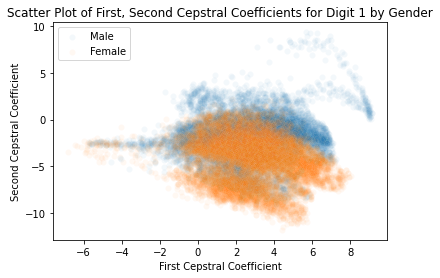

In [81]:
sns.scatterplot(df2_genderblocked[2][0], df2_genderblocked[2][1], alpha=0.05)
sns.scatterplot(df2_genderblocked[3][0], df2_genderblocked[3][1], alpha=0.05)
plt.title("Scatter Plot of First, Second Cepstral Coefficients for Digit 1 by Gender")
plt.legend(("Male", "Female"))
plt.xlabel("First Cepstral Coefficient")
plt.ylabel("Second Cepstral Coefficient")
plt.savefig("cepstralbygender", dpi=300)

In [18]:
male_gmms = []
female_gmms = []
for i in range(10):
    gmm_male = GaussianMixture(n_components=8, covariance_type='diag').fit(df2_genderblocked[2 * i])
    gmm_female = GaussianMixture(n_components=8, covariance_type='diag').fit(df2_genderblocked[2 * i + 1])
    male_gmms.append(gmm_male)
    female_gmms.append(gmm_female)

In [19]:
predictions_time = []
for i in range(2199):
    max_score = -10000
    max_GMM = -1
    if (int(int(i / 110) % 2) == 0):
        for gmm_num in range(len(male_gmms)):
            score = male_gmms[gmm_num].score(df_test_time[i])
            if score > max_score:
                max_GMM = gmm_num
                max_score = score
        predictions_time.append(max_GMM)
    else:
        for gmm_num in range(len(female_gmms)):
            score = female_gmms[gmm_num].score(df_test_time[i])
            if score > max_score:
                max_GMM = gmm_num
                max_score = score
        predictions_time.append(max_GMM)


In [8]:
for i in range(len(predictions_time)):
    if (predictions_time[i] % 2 == 0):
        predictions_time[i] /= 2
    else:
        predictions_time[i] = (predictions_time[i] - 1) / 2

for i in range(len(predictions_time)):
    predictions_time[i] = int(predictions_time[i])

pd.DataFrame(predictions_time)[0].unique()

0.9627103228740337
54
28


C:\Users\19083\anaconda3\envs\compsci371d\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


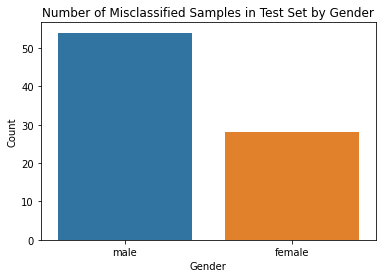

In [64]:
correct = 0
guy_wrong = 0
female_wrong = 0
wrongs = np.zeros(len(predictions_time))
wrongs = wrongs - 1
for i in range(len(predictions_time)):
    if predictions_time[i] == np.floor(i / 220):
        correct += 1
        wrongs[i] = predictions_time[i]
    else:
        if (int(int(i / 110) % 2) == 0):
            guy_wrong += 1
        else:
            female_wrong += 1

print(correct / 2199)
print(guy_wrong)
print(female_wrong)

results = {'male': guy_wrong, 'female': female_wrong}
sns.barplot(list(results.keys()), list(results.values()))
plt.title("Number of Misclassified Samples in Test Set by Gender")
plt.ylabel("Count")
plt.xlabel("Gender")
plt.savefig("ResultsbyGender", dpi=300)

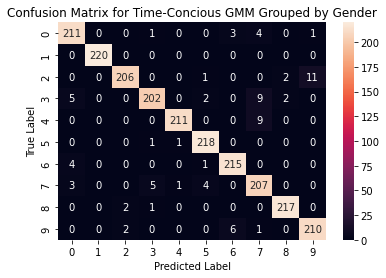

In [65]:
labels = []
for i in range(2199):
    labels.append(int(i/220))

cm = pd.DataFrame(confusion_matrix(labels, predictions_time))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix for Time-Concious GMM Grouped by Gender')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig("emgender_confusion_matrix.png", dpi=300)

In [69]:
testpredictions_time = []
for i in range(6599):
    max_score = -10000
    max_GMM = -1
    if (int(int(i / 330) % 2) == 0):
        for gmm_num in range(len(male_gmms)):
            score = male_gmms[gmm_num].score(df2_train[i])
            if score > max_score:
                max_GMM = gmm_num
                max_score = score
        testpredictions_time.append(max_GMM)
    else:
        for gmm_num in range(len(female_gmms)):
            score = female_gmms[gmm_num].score(df2_train[i])
            if score > max_score:
                max_GMM = gmm_num
                max_score = score
        testpredictions_time.append(max_GMM)

In [72]:
correct = 0
guy_wrong = 0
female_wrong = 0
wrongs = np.zeros(len(testpredictions_time))
wrongs = wrongs - 1
for i in range(len(testpredictions_time)):
    if testpredictions_time[i] == np.floor(i / 660):
        correct += 1
        wrongs[i] = testpredictions_time[i]
    else:
        if (int(int(i / 330) % 2) == 0):
            guy_wrong += 1
        else:
            female_wrong += 1

print(correct / 6600)
print(guy_wrong)
print(female_wrong)

0.9806060606060606
64
63


In [16]:
count = 0
for i in range(2199):
    if((int(int(i / 110) % 2) == 0)):
        count+= 1;

count


1100